In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop





In [2]:
##install package required for creating training,test and validation folders of images
!pip install split_folder

In [3]:
import splitfolders
input_folder = 'AnacondaImageClassification'
output = 'AnacondaImageClassification_TrainingSetV2'

#Percentage ratio that were dividing the data up into 6-/20/20 data split
splitfolders.ratio(input_folder,output,seed=42, ratio=(.6,.2,.2))

Copying files: 481 files [00:02, 205.34 files/s]


In [4]:
help(splitfolders.ratio)

Help on function ratio in module splitfolders.split:

ratio(input, output='output', seed=1337, ratio=(0.8, 0.1, 0.1), group_prefix=None)



### Start of the image classification

In [69]:
from tensorflow.keras.layers import Conv2D, Flatten,Dense, MaxPool2D, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np


In [70]:
img_height, img_width = (736,740)
batch_size = 32

train_data_dir = r"AnacondaImageClassification_TrainingSet/train"
valid_data_dir = r"AnacondaImageClassification_TrainingSet/val"
test_data_dir = r"AnacondaImageClassification_TrainingSet/test"


In [71]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.4)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height,img_width),
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
    #validation_data_dir,
    #target_size=(img_width,img_height),
    #batch_size=batch_size,
    #class_mode='binary'
)

Found 132 images belonging to 7 classes.
Found 84 images belonging to 7 classes.


In [72]:
test_generator = train_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height,img_width),
    batch_size=1,
    class_mode='categorical',
    subset='validation')

Found 24 images belonging to 7 classes.


In [73]:
x,y = test_generator.next()
x.shape

(1, 736, 740, 3)

In [74]:
train_generator.num_classes

#other class is inpy checkpoint incase curious

7

In [75]:
base_model = ResNet50(include_top=False, weights='imagenet') #set to false as true is used for more than a thousnad classes
#we are only using 6 classes
#Imagenet transfer learning model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

#Transfer Learning Model
predictions = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input,outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False
    
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])
model.fit(train_generator,
         epochs = 4)

Epoch 1/4
5/5 [==============================] - 169s 40s/step - loss: 4.4461 - accuracy: 0.2091
Epoch 2/4
5/5 [==============================] - 164s 31s/step - loss: 0.6020 - accuracy: 0.6768
Epoch 3/4
5/5 [==============================] - 161s 39s/step - loss: 0.5601 - accuracy: 0.6454
Epoch 4/4
5/5 [==============================] - 163s 30s/step - loss: 0.1899 - accuracy: 0.8651


In [76]:
model.save('C:/Users/Fujitsu/Desktop/image_classification/RestNet50_WaterSample1')

INFO:tensorflow:Assets written to: C:/Users/Fujitsu/Desktop/image_classification/RestNet50_WaterSample1\assets


In [77]:
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print('\nTest Accuracy:', test_acc)

24/24 - 30s - loss: 0.5055 - accuracy: 0.7500

Test Accuracy: 0.75


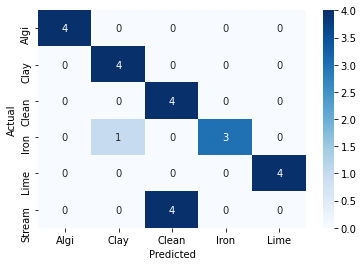

test accuracy : 79.16666666666666


In [78]:
import pandas as pd
import seaborn as sn
import tensorflow as tf

model = tf.keras.models.load_model('C:/Users/Fujitsu/Desktop/image_classification/RestNet50_WaterSample1')
filenames = test_generator.filenames
nb_samples = len(test_generator)
y_prob=[]
y_act=[]
test_generator.reset()
for _ in range(nb_samples):
    X_test,Y_test = test_generator.next()
    y_prob.append(model.predict(X_test))
    y_act.append(Y_test)
    
    
predicted_class = [list(train_generator.class_indices.keys())[i.argmax()]for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()]for i in y_act] 

out_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns=['predicted_class','actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'],rownames=['Actual'],colnames=['Predicted'])

sn.heatmap(confusion_matrix,cmap='Blues', annot=True,fmt='d')
plt.show()
print('test accuracy : {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))